-45deg 12.5 8.5 5.5
45deg 8.7 12 3.7
0deg 13.45 9.75 3.45


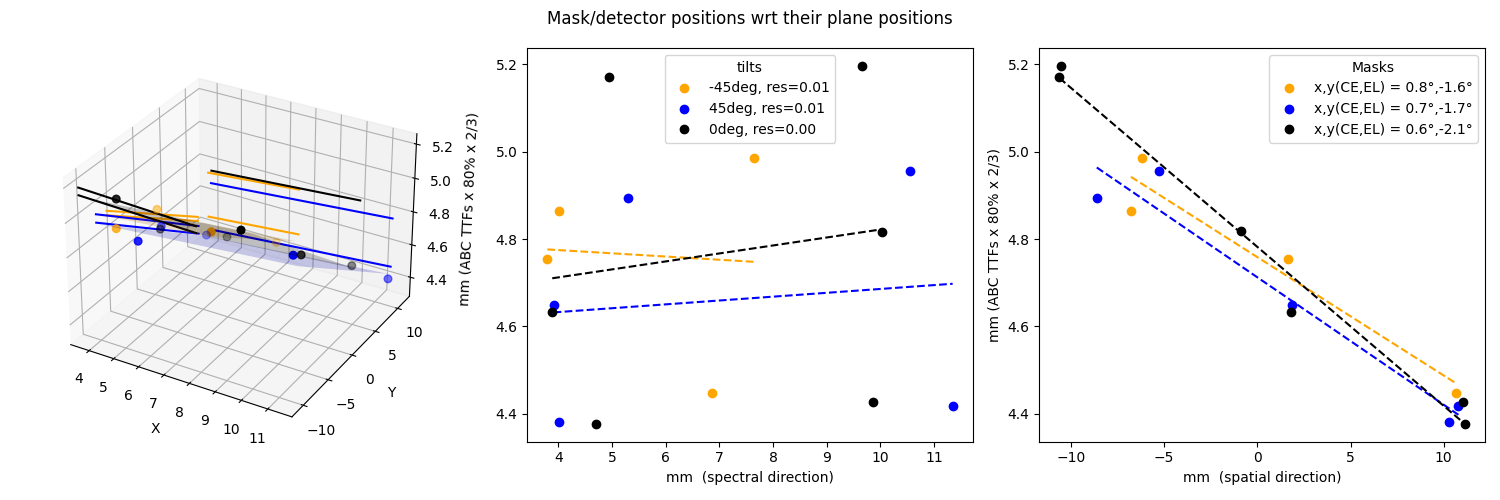

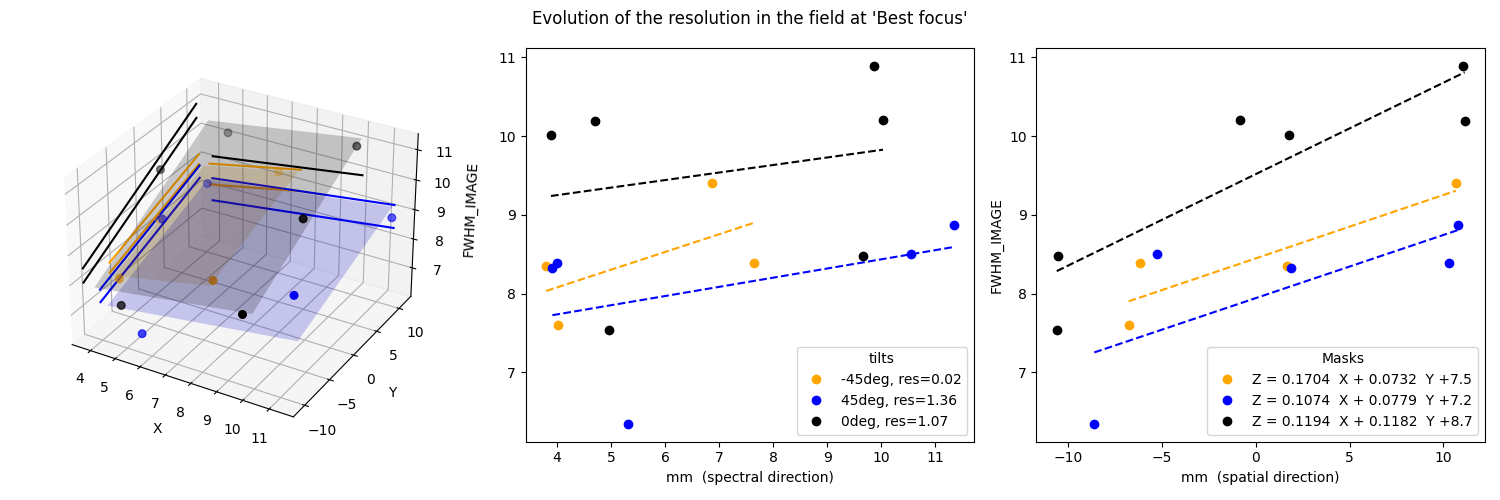

In [81]:
%matplotlib widget
import sys
# sys.path.insert(0,'/content/pyds9plugin')
from astropy.table import Table
import matplotlib.pyplot as plt
import glob
import numpy as np
# from google.colab import drive
# from google.colab import files

from pyds9plugin.DS9Utils import PlotFit1D

def fit_quadratic_curve(x, y, z, sigma_z=None, order=2, Plot=True, n=100, ax=None, c="r", title=None,legend=""):
    """Linear or quadratic fit of data
    """
    import matplotlib
    import matplotlib.cm as cmx
    from scipy import linalg

    cm = plt.get_cmap("twilight_shifted")
    cNorm = matplotlib.colors.Normalize(vmin=1, vmax=4)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

    if sigma_z is None:
        index = np.isfinite(z)
        #        data = np.array(zip(x[index],y[index],z[index]))
        data = np.array([x[index], y[index], z[index]]).T
    else:
        index = (np.isfinite(z)) & (np.isfinite(sigma_z))
        data = np.array(zip(x[index], y[index], z[index] / sigma_z[index]))
    # regular grid covering the domain of the data
    X, Y = np.meshgrid(np.linspace(x.min(), x.max(), n), np.linspace(y.min(), y.max(), n))
    # X, Y = np.meshgrid(np.linspace(0, x.max(), n), np.linspace(0, y.max(), n))
    XX = X.flatten()
    YY = Y.flatten()

    order = order  # 1: linear, 2: quadratic
    if order == 1:
        # best-fit linear plane
        if sigma_z is None:
            A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        else:
            A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])] / sigma_z[:, np.newaxis]

        C, _, _, _ = linalg.lstsq(A, data[:, 2])  # coefficients
        # evaluate it on grid
        Z = C[0] * X + C[1] * Y + C[2]
        z_plane = C[0] * x + C[1] * y + C[2]
        res = np.sum(np.square(z - z_plane))
        # or expressed using matrix/vector product
        # Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)
        l ="%s: Z = %0.4f * X + %0.4f * Y +%0.1f\nangles x,y(CE,EL) = %0.1fdeg,%0.1fdeg"%(legend,C[0], C[1], C[2],180*np.arctan(C[0])/np.pi,180*np.arctan(C[1])/np.pi)
    elif order == 2:
        if sigma_z is None:
            # best-fit quadratic curve
            A = np.c_[np.ones(data.shape[0]), data[:, :2], np.prod(data[:, :2], axis=1), data[:, :2] ** 2]
        else:
            # best-fit quadratic curve
            A = np.c_[np.ones(data.shape[0]), data[:, :2], np.prod(data[:, :2], axis=1), (data[:, :2] ** 2)] / sigma_z[:, np.newaxis]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        # evaluate it on a grid
        Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX * YY, XX ** 2, YY ** 2], C).reshape(X.shape)
        z_plane = np.dot(np.c_[np.ones(x.shape), x, y, x * y, y ** 2, y ** 2], C).reshape(X.shape)
        res = np.sum(np.square(z - z_plane))
        l = C
    if Plot:
        if ax is None:
            fig = plt.figure()#figsize=(15, 10))  # (10,8)
            # ax = fig.gca(projection="3d")
            ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2,color = c)
        # ax.contour3D(X, Y, Z, 55, cmap=c)#cmap="twilight_shifted")
        # ax.scatter(data[:, 0], data[:, 1], z[index], s=20, c=scalarMap.to_rgba(z[index]))  # cmap='twilight_shifted',vmin=1,vmax=4)
        
        ax.scatter(data[:, 0], data[:, 1], z[index], s=30, color=c,label=l)  # cmap='twilight_shifted',vmin=1,vmax=4)
        ax.contour(X, Y, Z, zdir='x', colors=[c,c],levels=1, offset=np.min(ax.get_xlim()))#[X.min(),X.max()]) offset=-4, 
        ax.contour(X, Y, Z, zdir='y',  colors=[c,c],levels=1, offset=   np.max(ax.get_ylim()))#[Y.min(),Y.max()])offset=   10,

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        # ax.legend(fontsize=8)
        ax.set_zlabel("Z")
        # scalarMap.set_array(z[index])
        try:
            fig.colorbar(scalarMap)#, fraction=0.016, pad=-0.2
        except UnboundLocalError:
            pass
        ax.axis("tight")
        if title is not None:
            ax.set_title(title)
    else:
        ax = 1
    return X, Y, Z, ax, C, res
#MGS raised 400mu
#detector lowered by 230 mu

def plot_masks(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks/*/", factor = 2/3,n=1, z_direction=None,title=None,ABCs=None):
    c="k"    
    cat = Table( names=("name", "cx", "cy", "c0","tx","ty"),dtype=[str,float,float,float,float,float])
    fig = plt.figure(figsize=(15,5))#,sharey=True, subplot_kw={'projection': "3d"})
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax0 = fig.add_subplot(1, 3, 2)
    ax1 = fig.add_subplot(1, 3, 3)
    # fig = plt.figure(figsize=(5,15))#,sharey=True, subplot_kw={'projection': "3d"})
    # ax = fig.add_subplot(3, 1, 1, projection='3d')
    # ax0 = fig.add_subplot(3, 1, 2)
    # ax1 = fig.add_subplot(3, 1, 3)
    folders = glob.glob(path)[:]
    # print("folders: ", folders)
    for j, (folder,c) in enumerate(zip(folders,["orange","b","k","g","r","grey","brown"]*10)):
        x,y,z=[],[],[]
        # files = glob.glob(folder + "/**/**/*_cat.fits")
        files = glob.glob(folder + "/*_cat.fits")
        if len(files)>2:
            for jj, f in enumerate(files):
                a = Table.read(f)
                i =float(a["Center"][0])*n
                x.append(float(a["X_IMAGE_PSF"][0]))#*0.013)
                y.append(float(a["Y_IMAGE_PSF"][0]))#*0.013)
                type = "guider" if "LINAENC" in a.colnames else "detector"
                ls = ":" if "LINAENC" in a.colnames else "--"
                if z_direction is None:
                    if "LINAENC" in a.colnames:
                        Amin,Bmin,Cmin = float(a["LINAENC"][0]), float(a["LINBENC"][0]), float(a["LINCENC"][0])
                        Amax,Bmax,Cmax = float(a["LINAENC"][-1]), float(a["LINBENC"][-1]), float(a["LINCENC"][-1])
                        AS,BS,CS = np.linspace(Amin,Amax,11*n), np.linspace(Bmin,Bmax,11*n), np.linspace(Cmin,Cmax,11*n)
                        zi = factor * (float(AS[int(i)])+float(BS[int(i)])+float(CS[int(i)]))/ 3
                        # ls=":"
                    else:
                        # ls="--"
                        A,B,C = ABCs[j]
                        if jj==0:
                            print(folder.split("/")[-2].split("_")[-1] ,  A,B,C )

                        # AS,BS,CS = np.linspace(A-5*0.25,A+5*0.25,11), np.linspace(B-5*0.25,B+5*0.25,11), np.linspace(C-5*0.25,C+5*0.25,11)
                        AS,BS,CS = np.linspace(A+5*0.25,A-5*0.25,11*n), np.linspace(B+5*0.25,B-5*0.25,11*n), np.linspace(C+5*0.25,C-5*0.25,11*n)
                        # zis = np.linspace(,,11)
                        # i = np.argmin(a["FWHM_IMAGE"])
                        zi = factor *(AS[int(i)]+BS[int(i)]+CS[int(i)])/ 3
                        # type="detector"
                        # zi = np.min(a["FWHM_IMAGE"])
                        # x.append(a["x_real_center"][0])
                        # y.append(a["y_real_center"][0])
                else:
                    # ls="--"
                    zi = np.min(a[z_direction])
                z.append(zi)
            if type=="detector":
                x = (np.array(x) - 1500)*0.013
                y = (np.array(y) - 1000)*0.013

                x+=1000*0.013/4
            else:
                x = (np.array(x) - 1280/2)*0.013
                y = (np.array(y) -  1080/2)*0.013


                # y*=-1

            X, Y, Z, ax, C, res = fit_quadratic_curve(np.array(x), np.array(y), np.array(z), sigma_z=None, order=1, Plot=True, n=100, ax=ax, c=c, title=None,legend=folder.split("/")[-2].split("_")[-1])

            if z_direction is None:
                label = "x,y(CE,EL) = %0.1f°,%0.1f°"%(180*np.arctan(C[0])/np.pi,180*np.arctan(C[1])/np.pi)
            else:
                label = "Z = %0.4f  X + %0.4f  Y +%0.1f"%(C[0], C[1], C[2])

            cat.add_row([folder.split("/")[-1],C[0], C[1], C[2],180*np.arctan(C[0])/np.pi,180*np.arctan(C[1])/np.pi])
            
            l = ax0.plot(np.array(x),  np.array(z),"o",c=c,label=folder.split("/")[-2].split("_")[-1] + ", res=%0.2f"%(res))
            a = PlotFit1D(np.array(x),  np.array(z), ax=ax0, deg=1, plot_=True, ls=ls,c=l[0].get_color(),extrapolate=False)#,lw=lw,sigma=err[mask ])
            ax1.plot(np.array(y),  np.array(z),"o",c=c, label = label)
            a = PlotFit1D(np.array(y),  np.array(z), ax=ax1, deg=1, plot_=True, ls=ls,c=l[0].get_color(),extrapolate=False)#,lw=lw,sigma=err[mask ])
        
        if z_direction is None:
            ax.set_zlabel("mm (ABC TTFs x 80% x 2/3)")
            # ax.set_title("Mask/detector positions wrt their plane positions")
            # ax1.set_ylabel("mm  (ABC TTFs x 2/3)")
            ax1.set_ylabel("mm (ABC TTFs x 80% x 2/3)")
        else:
            ax.set_zlabel(z_direction)
            ax1.set_ylabel(z_direction)
            # ax.set_title("Mask/detector positions wrt their plane positions")

    ax1.legend(title="Masks")
    ax0.legend(title="tilts")
    # ax.set_title("ROT = %s"%(folder.split("/")[-2]))
    # ax.set_zlim((7.6,10.6))

    # ax.set_xlim((-4,6))
    # ax.set_ylim((-7.5,10))

    # ax.set_box_aspect([1,1,1])
    ax1.set_xlabel("mm  (spatial direction)")
    ax0.set_xlabel("mm  (spectral direction)")
    fig.suptitle(title)
    fig.tight_layout()

    # plt.savefig(folder + "/Focal_plane_fit.png", dpi=100, bbox_inches="tight")
    # plt.savefig(os.path.dirname(folder) + "/Focal_plane_fit_%s.png"%(folder.split("/")[-1]))
    cat.to_pandas().to_clipboard()
    plt.show()
    return fig, (ax, ax0, ax1)
        


def plot_tilt_and_fwhm(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks/*/", factor = 2/3,n=1, z_direction=None,title=None, ABCs=None):
    fig, (ax, ax0, ax1) = plot_masks(path=path, z_direction=None, title="Mask/detector positions wrt their plane positions",ABCs=ABCs,n=10,factor=0.8*2/3)
    fig, (ax, ax0, ax1) = plot_masks(path=path,  z_direction="FWHM_IMAGE" , title="Evolution of the resolution in the field at 'Best focus'")
    return fig, (ax, ax0, ax1)


fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230602/*deg/*", ABCs=[[12.5, 8.5, 5.5],[8.7, 12, 3.7],[13.45, 9.75, 3.45]])

DETECTOR 15.2 10.5 9.95


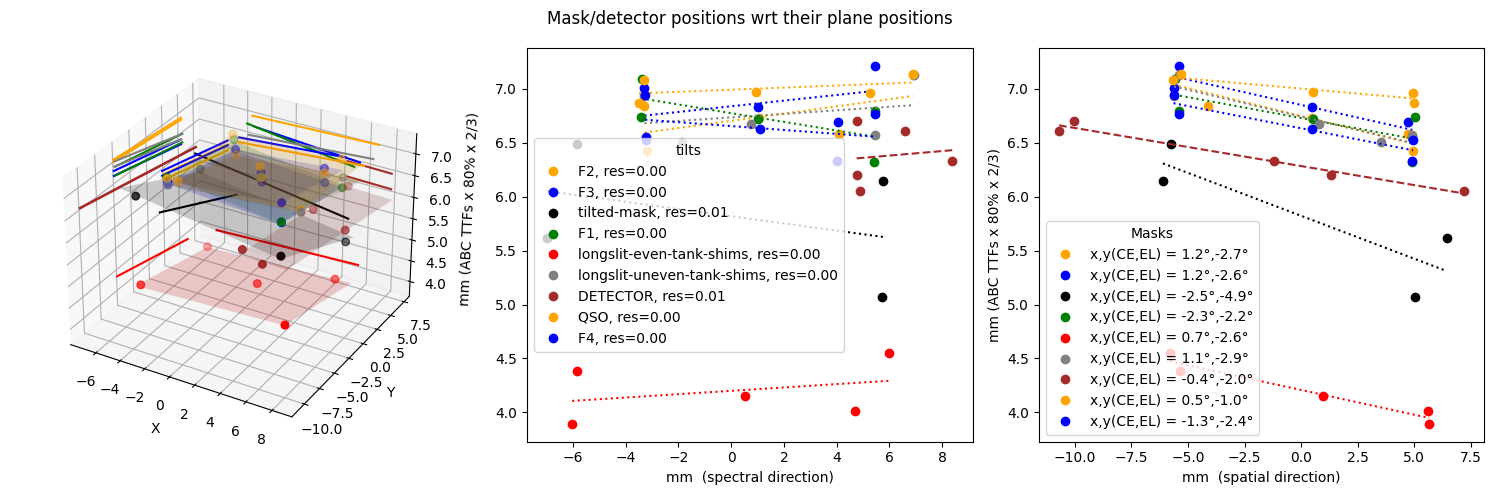

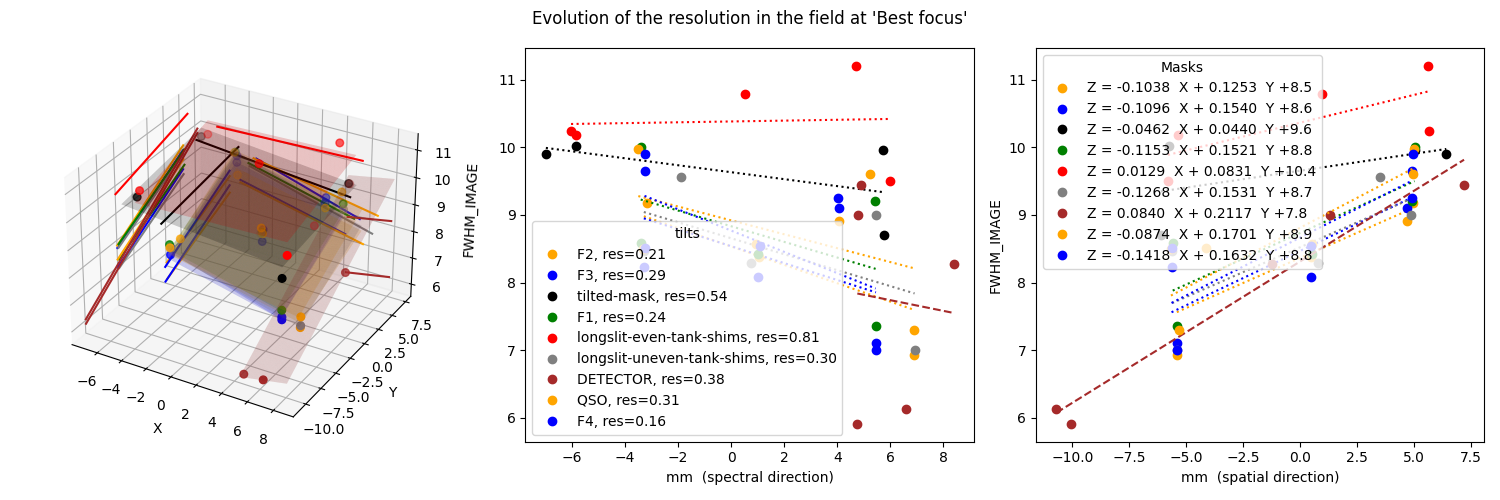

In [107]:
fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[[15.2,10.5,9.95]]*10,path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/*/")

# fig, (ax, ax0, ax1) = plot_masks(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[15.2,10.5,9.95],path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/*/")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


folders:  ['/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/ROTENC_19_F2/', '/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/ROTENC_59_F3/', '/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/ROTENC_-61_F1/', '/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/ROTENC_-141_longslit-even-tank-shims/', '/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/con

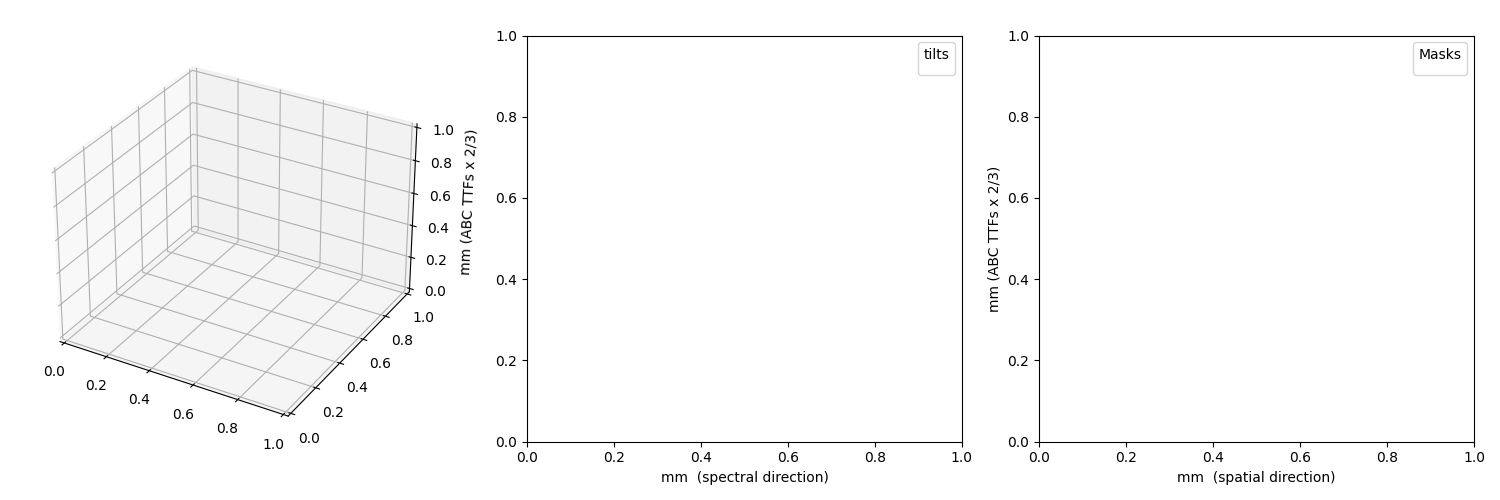

In [18]:
fig, (ax, ax0, ax1) = plot_masks(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/*/",n=10,factor=0.8*2/3)
# fig, (ax, ax0, ax1) = plot_masks(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/ROTENC_-*long*/",title="Mask/detector positions wrt their plane positions",n=10,factor=0.8*2/3)#, z_direction="FWHM_IMAGE")


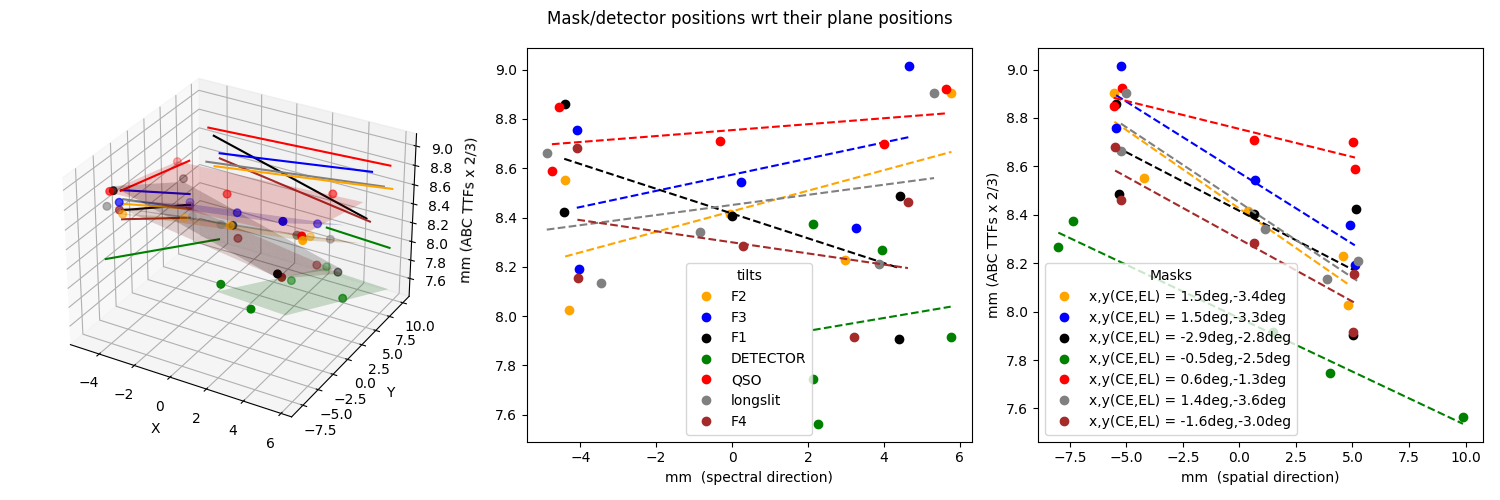

In [30]:
fig, (ax, ax0, ax1) = plot_masks(title="Mask/detector positions wrt their plane positions",n=10,factor=0.8*2/3)



-45deg 12.5 8.5 5.5
45deg 8.7 12 3.7
0deg 13.45 9.75 3.45


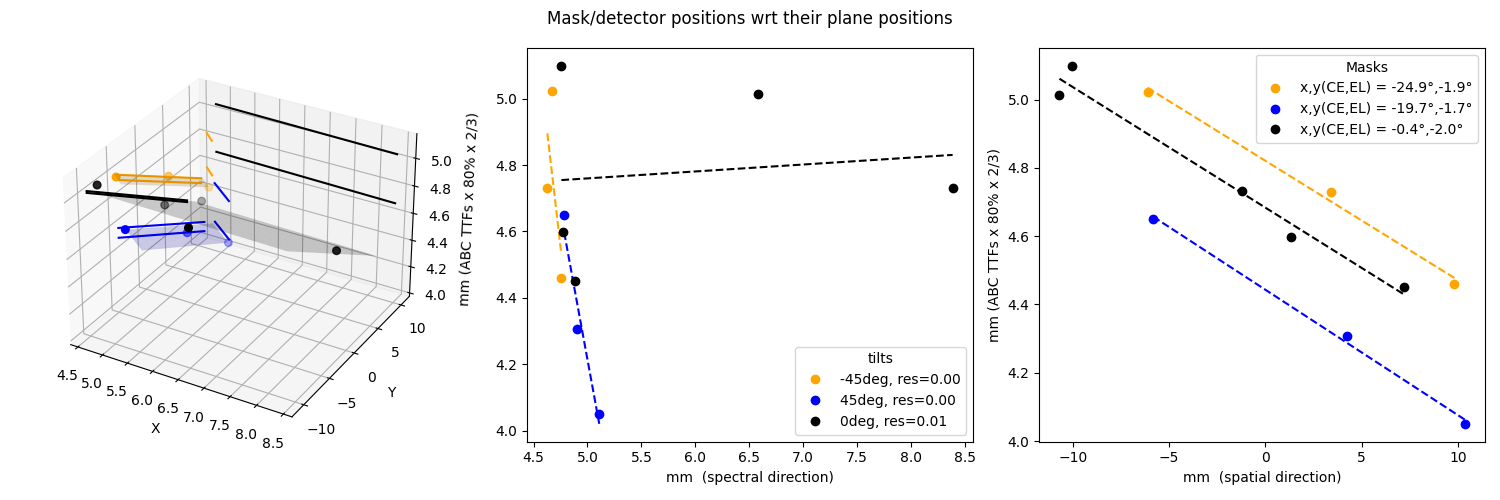

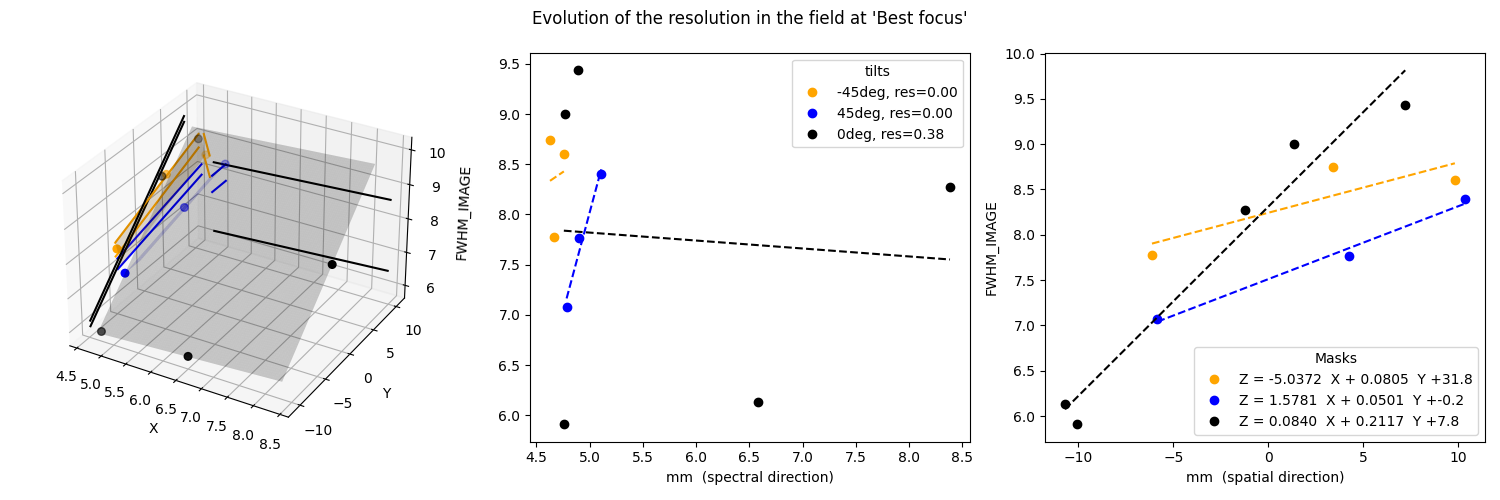

In [110]:
fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230525/thrufocus2/ROT/*/*", ABCs=[[12.5, 8.5, 5.5],[8.7, 12, 3.7],[13.45, 9.75, 3.45]])

In [84]:
    # for folder,c in zip(glob.glob("/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks/DETECTOR/")[:],["orange","b","k","g","r","orange"]):
    # folder = "/Users/Vincent/DS9QuickLookPlugIn/subsets/confocality_masks/DETECTOR"
        # for f in glob.glob("/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230425/through_focus/?/*_cat.fits"):
        # for f in glob.glob("/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230525/dets/*_cat.fits"):
        # paths=glob.glob("/Users/Vincent/DS9QuickLookPlugIn/subsets/230413_16H00m22/ROTENC_-20.99998/**/**/Th*.csv")
        # stack_images_path(paths, Type="nanmean", clipping=3, dtype=float, fname="", std=False, name=None)    
            # print(f)
            # a = Table.read(os.path.dirname(paths[0])+"/stack_cat.csv")
